In [1]:
# === Step 1: Environment Setup and Data Download ===

# 1. Install the Kaggle library to interact with their API
!pip install kaggle -q

# 2. Upload the kaggle.json file to link your account
from google.colab import files
import os

print('Please upload the kaggle.json file you downloaded from your Kaggle account')
# You will be prompted to upload the file. Upload it to continue.
uploaded = files.upload()

# Ensure the file was uploaded before proceeding
if 'kaggle.json' not in uploaded:
    raise ValueError("kaggle.json file not uploaded! Please restart the cell and upload the file.")

# 3. Set up the Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download and extract the dataset
# Link: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
print("\n⏳ Downloading data from Kaggle...")
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# The file will be downloaded as archive.zip
print("\n📦 Extracting data...")
!unzip -q brain-tumor-mri-dataset.zip -d .

print("\n✅ Environment and data prepared successfully!")

# Display folder contents to confirm correct extraction
print("\n📂 Current folder contents:")
!ls

Please upload the kaggle.json file you downloaded from your Kaggle account


Saving kaggle.json to kaggle.json

⏳ Downloading data from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 79% 118M/149M [00:00<00:00, 1.23GB/s]
100% 149M/149M [00:00<00:00, 1.13GB/s]

📦 Extracting data...

✅ Environment and data prepared successfully!

📂 Current folder contents:
brain-tumor-mri-dataset.zip  kaggle.json  sample_data  Testing	Training


In [26]:
# === Step 2: Import Libraries and Functions ===

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")




In [27]:
# Define functions to create DataFrames from image paths
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df


def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

print("Libraries imported and functions defined successfully.")

Libraries imported and functions defined successfully.


In [32]:
# === Step 3: Load Data and Create DataFrames ===

# Adjust paths for your environment
train_path = './Training'
test_path = './Testing'

# Create DataFrames from the directories
tr_df = train_df(train_path)
ts_df = test_df(test_path)

# Split full_train_df into train and validation sets (e.g., 80/20)
train_df_split, valid_df = train_test_split(
    tr_df,
    test_size=0.2,
    random_state=42,
    stratify=tr_df['Class']
)

print("Training data:")
print(train_df_split.head())
print("\nValidation data:")
print(valid_df.head())
print("\nTest data:")
print(ts_df.head())




Training data:
                                Class Path       Class
2079  ./Training/meningioma/Tr-me_0219.jpg  meningioma
1502     ./Training/notumor/Tr-no_0112.jpg     notumor
4722      ./Training/glioma/Tr-gl_0923.jpg      glioma
2022  ./Training/meningioma/Tr-me_0676.jpg  meningioma
3726   ./Training/pituitary/Tr-pi_1248.jpg   pituitary

Validation data:
                                Class Path       Class
2444  ./Training/meningioma/Tr-me_1150.jpg  meningioma
3781   ./Training/pituitary/Tr-pi_0473.jpg   pituitary
2874  ./Training/meningioma/Tr-me_0883.jpg  meningioma
3247   ./Training/pituitary/Tr-pi_1270.jpg   pituitary
204      ./Training/notumor/Tr-no_0813.jpg     notumor

Test data:
                         Class Path    Class
0  ./Testing/notumor/Te-no_0040.jpg  notumor
1  ./Testing/notumor/Te-no_0072.jpg  notumor
2  ./Testing/notumor/Te-no_0229.jpg  notumor
3  ./Testing/notumor/Te-no_0273.jpg  notumor
4  ./Testing/notumor/Te-no_0331.jpg  notumor


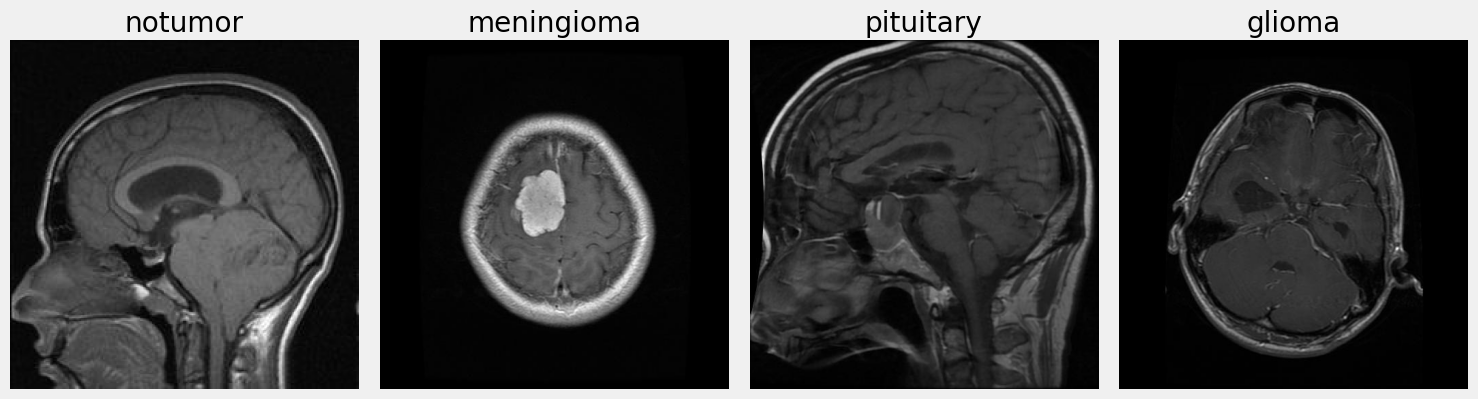

In [ ]:
import matplotlib.pyplot as plt
import cv2

df = tr_df.copy()

unique_classes = df['Class'].unique()

n_classes = len(unique_classes)
plt.figure(figsize=(15, 5))

for i, class_name in enumerate(unique_classes):
    sample_path = df[df['Class'] == class_name]['Class Path'].values[0]

    img = cv2.imread(sample_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, n_classes, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


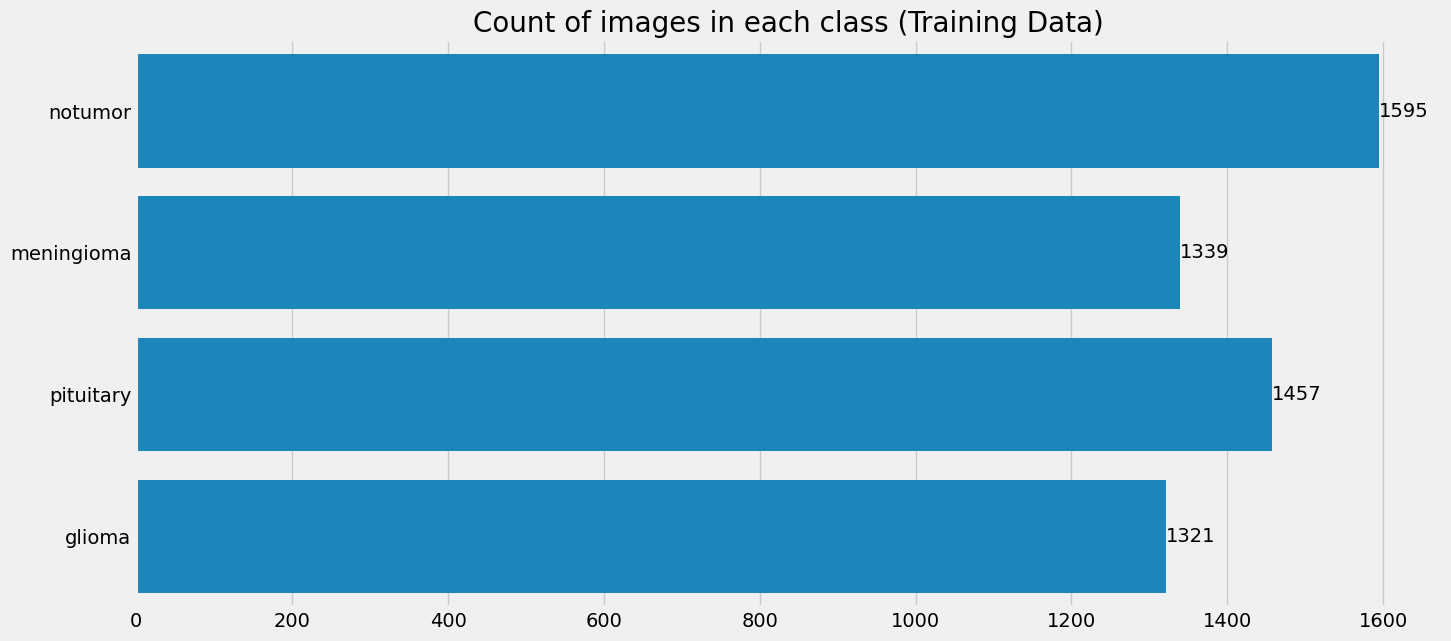

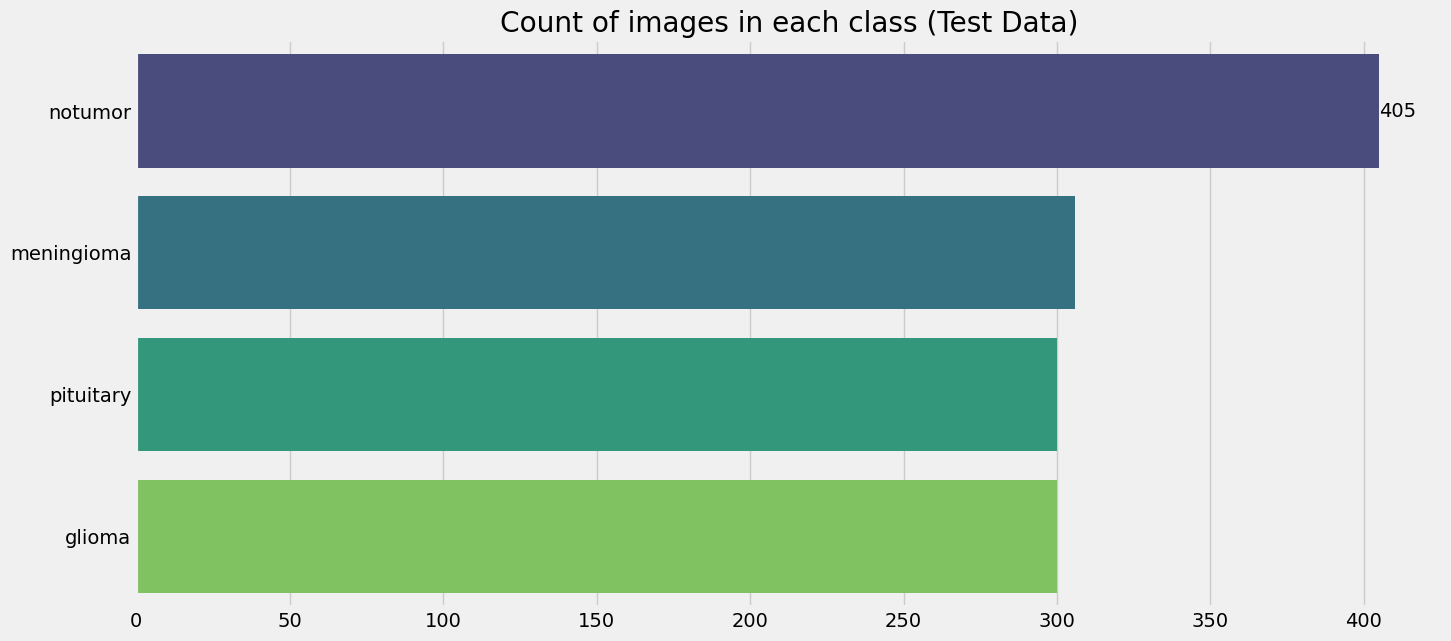

In [33]:
# === Step 4: Analyze and Visualize Data ===

# Display the count of images in each class (Training Data)
plt.figure(figsize=(15,7))
ax_train = sns.countplot(data=tr_df , y=tr_df['Class'])
plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class (Training Data)', fontsize=20)
ax_train.bar_label(ax_train.containers[0])
plt.show()

# Display the count of images in each class (Original Test Data before splitting)
plt.figure(figsize=(15, 7))
ax_test = sns.countplot(y=ts_df['Class'], palette='viridis')
ax_test.set(xlabel='', ylabel='', title='Count of images in each class (Test Data)')
ax_test.bar_label(ax_test.containers[0])
plt.show()

In [ ]:
# === Step 5: Prepare Data Generators ===

batch_size = 32
img_size = (299, 299)

# Data generator for training and validation (with slight data augmentation)
_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.9, 1.1),
    fill_mode='nearest'
)

# Data generator for testing (only rescaling)
ts_gen_instance = ImageDataGenerator(rescale=1./255)

# Link generators to DataFrames
tr_gen = _gen.flow_from_dataframe(train_df_split, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)


valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen_instance.flow_from_dataframe(ts_df, x_col='Class Path',
                                             y_col='Class', batch_size=16,
                                             target_size=img_size, shuffle=False)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [20]:
# === Step 6: Build the Model ===

img_shape=(299,299,3)

# Load the base model (Xception) with ImageNet weights
base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet",
                                            input_shape=img_shape, pooling='max')

# Build the final model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [37]:
print("Training:", len(train_df_split))
print("Validation:", len(valid_df))
print("Test:", len(ts_df))


Training: 4569
Validation: 1143
Test: 1311


In [23]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle=False,
                 callbacks=[early_stop])


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.7234 - loss: 0.7638 - precision_1: 0.8213 - recall_1: 0.6199 - val_accuracy: 0.8959 - val_loss: 0.2946 - val_precision_1: 0.9114 - val_recall_1: 0.8731
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 137s 955ms/step - accuracy: 0.9590 - loss: 0.1194 - precision_1: 0.9624 - recall_1: 0.9568 - val_accuracy: 0.9703 - val_loss: 0.0908 - val_precision_1: 0.9711 - val_recall_1: 0.9694
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 136s 951ms/step - accuracy: 0.9888 - loss: 0.0313 - precision_1: 0.9890 - recall_1: 0.9886 - val_accuracy: 0.9755 - val_loss: 0.0868 - val_precision_1: 0.9755 - val_recall_1: 0.9755
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 136s 951ms/step - accuracy: 0.9929 - loss: 0.0228 - precision_1: 0.9930 - recall_1: 0.9927 - val_accuracy: 0.9668 - val_loss: 0.1241 - val_precision_1: 0.9684 - val_recall_1: 0.9668
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 136s 953ms/step - accuracy: 0.9939 - loss: 0.0264 - precision_1: 0.9939 - r

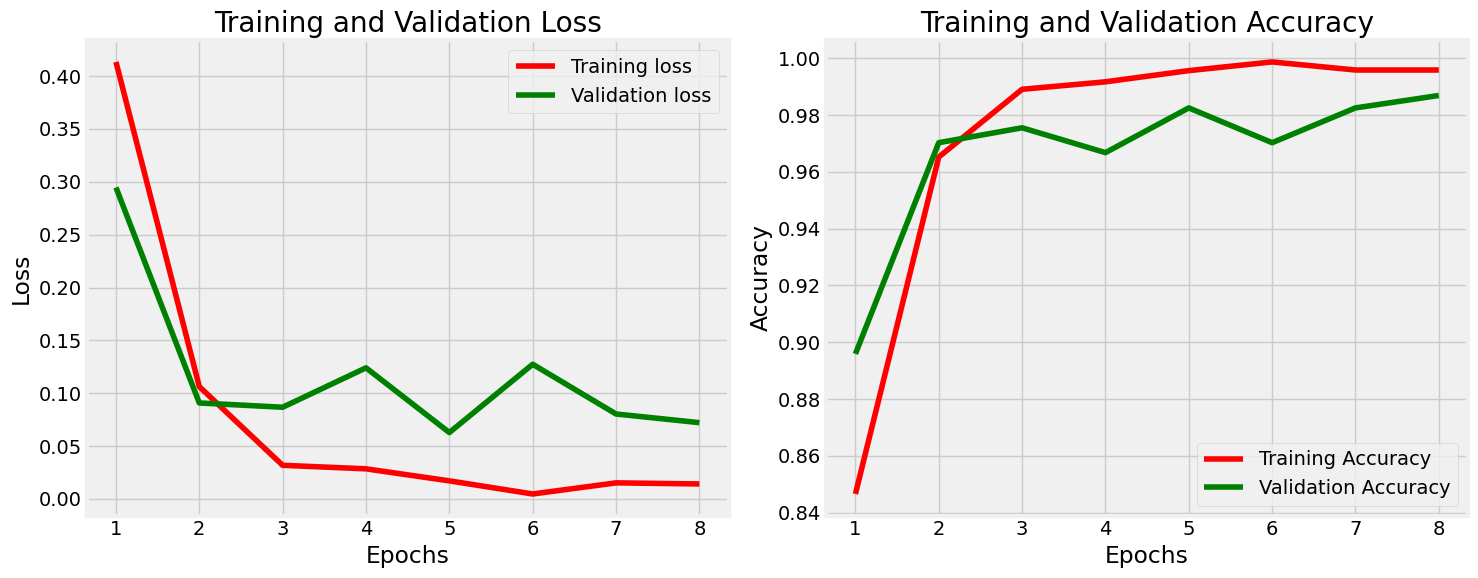

--- Model Performance Evaluation ---
Train Loss: 0.0021, Train Accuracy: 99.96%
Validation Loss: 0.0634, Validation Accuracy: 98.25%
Test Loss: 0.0379, Test Accuracy: 98.86%
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step


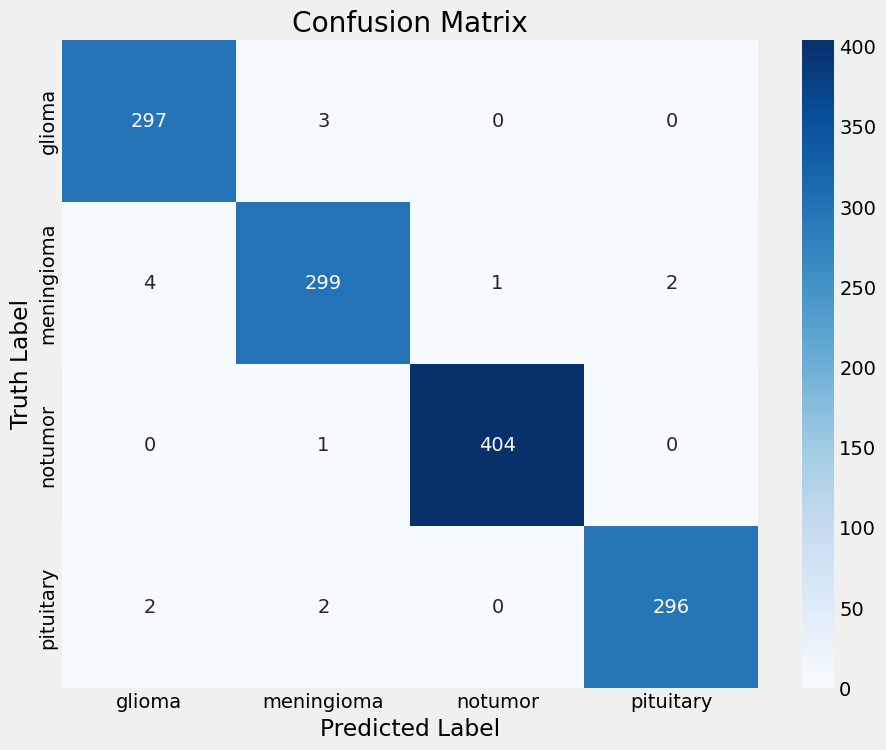


--- Classification Report ---

              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       300
  meningioma       0.98      0.98      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [24]:
# 1. Display training performance plots
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(15, 6))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Evaluate the model on all three sets
print("--- Model Performance Evaluation ---")
train_score = model.evaluate(tr_gen, verbose=0)
valid_score = model.evaluate(valid_gen, verbose=0)
test_score = model.evaluate(ts_gen, verbose=0)

print(f"Train Loss: {train_score[0]:.4f}, Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}, Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}, Test Accuracy: {test_score[1]*100:.2f}%")

# 3. Confusion Matrix and Classification Report
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
class_dict = tr_gen.class_indices
labels = list(class_dict.keys())

# Confusion Matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n--- Classification Report ---\n")
print(classification_report(ts_gen.classes, y_pred, target_names=labels))

In [25]:
model.save('brain_tumor_model.h5')

from google.colab import files
files.download('brain_tumor_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>